# Assignment 2

***

## Question 1: Neural Codes & Nearest Neighbor retrieval (7.5pt)
The Caltech101 dataset consists of images of 101 different objects. In this question you will develop an image retrieval system using image representations (neural codes) learned with a deep convolutional neural network and a given distance metric.

In the tasks below you will need to implement the following steps:

* Retrieval for $n$ selected (distinct) query images from the dataset
    * For each query image, obtain the 5 most similar images (excluding the query image itself!)
* Evaluation of the quality of the retrieval 
    * The Caltech101 images are annotated with their object class. Use these annotations to evaluate the accuracy of the retrieval task.
    * For each query image, count the number of images whose class corresponds to the one from the query. The score of the retrieval for that image then ranges between:
        * **5** *all* retrieved images' classes agree with the query image class
        * **0** *none* of the images' classes agree with the query image class
    * Compute the average of all $n$ queries

***

### Task 1.1:  Neural codes image retrieval
**a)** Implement the retrieval task and evaluate the results for $n=200$ images. Use the provided VGG16 network pre-trained on ImageNet to compute "neural codes" and L2-distance. Specifically use the codes produces by the following layers of the model: 
1. the "fc1"-layer
2. the "fc2"-layer

Provide the retrieval evaluation scores for both tasks.

In [22]:
# you'll need these imports:
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle

In [24]:
# NOTE: you will first need to apply some changes to "Practical-3.3.0_preprocess-caltech101.ipynb" and run it
#       to obtain a pickle file with "fc1"-features. You don't need to show these changes here.


# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
#for datapath in ("caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"):
for datapath in ("caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"):
    # load the dataset
    with open(os.path.join("data", datapath), "rb") as f:
        X_fc, y, X_paths, classes = pickle.load(f)
        
    
    ## Construct nearest neighbors data structure. L2 distance is selected (p=2)
    neigh = NearestNeighbors(n_neighbors=6, p=2)
    neigh.fit(X_fc)
    
    ## compute score
    total_score = 0
    X = X_fc[indices]
    nn = neigh.kneighbors(X)
    nn_indices = nn[1]
    for neighbors in nn_indices:
        target = neighbors[0]
        target_class = y[target]
        closest_neighbors = neighbors[1:]
        neighbors_classes = y[closest_neighbors]
        for nclass in neighbors_classes:
            if target_class == nclass:
                total_score+=1
                
    score =(total_score*1.0)/n
    print("Average score for image retrieval task using {}: {:.2f}".format(datapath, score))


Average score for image retrieval task using caltech101_VGG16_fc1.p: 3.82
Average score for image retrieval task using caltech101_VGG16_fc2.p: 4.01


***

**b)** Which representation ("neural code") provided better features for the given retrieval task? 
Justify your answer and discuss possible reasons for the observed results. Relate your answer to the conclusions in the paper "Neural Codes for Image Retrieval".

**Answer:**

From the average scores obtained before, we observe that the "fc2"-layer performs better than the "fc1"-layer for the retrieval task. The "fc2"-layer is one level deeper in the network architecture than the "fc1"-layer, and we expect deeper layers to compute more complex features than previous layers.

The results of Table 1 in the paper "Neural Codes for Image Retrieval" show that layer number 6 performs better than layers number 5 and 7. It is interesting to notice that the difference in performance between layers 6 and 7 is smaller than the difference in performance between layers 6 and 5. In this sense, the paper shows that fully connected layers tend to create better feature representation vectors than convolutional layers. From the paper's point of view the "fc1"-layer should have performed better than the "fc2"-layer, but from our results we observe that our first intuition was true. For the VGG16 architecture, the "fc2"-layer performs better than the "fc1"-layer.

***

### Task 1.2: Detailed evaluation
**a)** The retrieval scores can vary from one query image to another. Some images are quite representative and for them retrieval works well, some are not so much.
For the same retrieval task given above using "fc2"-features, find (if possible) six query images such that they range from excellent to poor retrieval performance. More specifically find example query images that result in query scores of exactly 0, 1, 2, 3, 4, and 5.

Visualise the six (or less) resulting query images.

In [23]:
# you'll need these extra imports:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [37]:
def show_images(query_path, targets, target_paths):
    
    query_image = image.load_img(query_path, target_size=(224,224))
    fig = plt.figure(figsize=(6,4))
    
    sub1 = fig.add_subplot(231)
    sub1.set_title('Query image')
    sub1.axis("off")
    sub1.imshow(query_image)
    
    for idx, target in enumerate(targets):
        target_path = target_paths[target]
        target_img = image.load_img(target_path, target_size=(224, 224))
        subfigure_number = 232 + idx
        subfigure = fig.add_subplot(subfigure_number)
        subfigure.set_title('Target {}'.format(idx + 1))
        subfigure.axis("off")
        subfigure.imshow(target_img)

    plt.show()

In [40]:
# load the dataset
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)

# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
# example usage given some index < 8677:
#index = 254
#show_img(X_paths[index])

def compute_score(imgs, y):
    target = imgs[0]
    score = 0
    for neighbor in imgs[1:]:
        #print("Target {}, neighbor {}".format(target, neighbor))
        if y[target] == y[neighbor]:
            score+=1
    return score


# === SOLUTION: ===
nn_xfc = NearestNeighbors(n_neighbors=6, p=2)
nn_xfc.fit(X_fc)

examples_found = False
example_scores = [-1, -1, -1, -1, -1, -1]
example_indexes = [-1, -1, -1, -1, -1, -1]
neighbors_indexes = {}
while not examples_found:
    index = random.randint(0, n-1)
    nn = nn_xfc.kneighbors(X_fc[index].reshape(1, -1))
    same_classes = compute_score(nn[1][0], y)
    example_scores[same_classes] = same_classes
    example_indexes[same_classes] = index
    neighbors_indexes[same_classes] = nn[1][0][1:]
    ## check if examples has the following elements [0, 1, 2, 3, 4, 5]
    #print(examples)
    if sum(example_scores) == 15:
        examples_found = True

        
    
    

Examples with score values [0,1,2,3,4,5]
[4851 4864 5239 5211 4825]
Example with score 0 belongs to class elephant


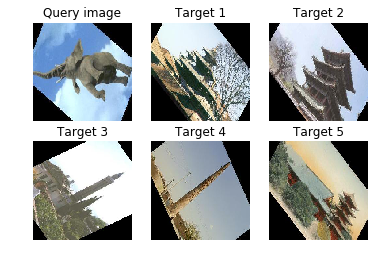

Example with score 1 belongs to class elephant


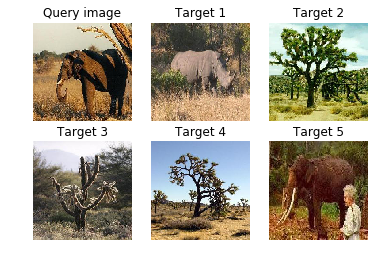

Example with score 2 belongs to class snoopy


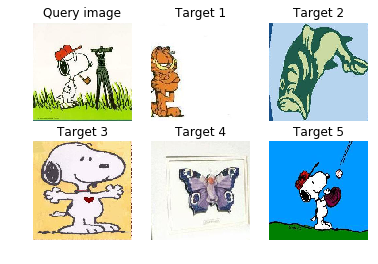

Example with score 3 belongs to class elephant


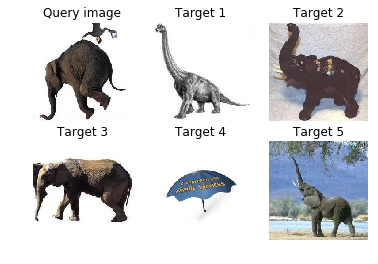

Example with score 4 belongs to class dalmatian


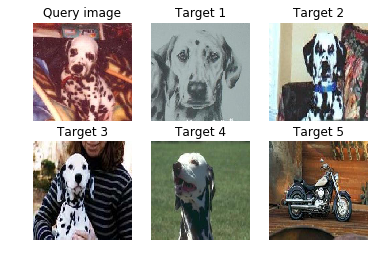

Example with score 5 belongs to class elephant


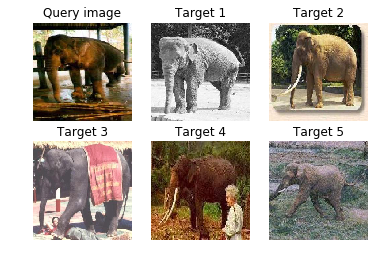

In [41]:
print("Examples with score values [0,1,2,3,4,5]")
print(neighbors_indexes[0])
#print(example_indexes)
for score, index in enumerate(example_indexes):
    print("Example with score {} belongs to class {}".format(score, classes[y[index]]))
    #show_img(X_paths[index])
    show_images(X_paths[index], neighbors_indexes[score], X_paths)


***

**b)** Looking at the results, what can you say about the "types" of images that obtain good retrieval scores compared to those obtaining poor retrieval scores? Give an explanation and possible solution(s).

(*HINT: How did we obtain data representations for similarity measures?*)

**Answer:**



Images that obtain bad retrieval scores usually contain few distinctive features from the class they belong to. Also, these images share several non relevant features with images of other classes, which make then very similar according to the NN classifier. For example, sometimes images from the class elephant that obtain low retrieval scores correspond to drawings, toys, or 3D models. But, images of real elephants usually obtain good retrieval scores. Something similar happens for images of dalmatians.

Images with good retrieval scores usually show the most relevant features of the class they belong to. For example, for elephants and dalmatians we have: nose, ears, shape, color, legs, eyes, etc.

Because the the data representations contain computed features from the original images, it is not a surprise to find non related images being classified as similar when they share many features as color, shape, size, texture, bright, etc.

To overcome this problem we propose two solutions.

First, apply data augmentation to eliminate the problems caused by non relevant features like light, orientation, and others.

Then, for each class identify the classes that are responsible for most of the misclassifications. Once these classes are obtained, modify the loss function such that during the training the network try to make the features of the correct class as different as possible to the features of the incorrect classes. We expect this approach to reduce the number of misclassifications during the retrieval task. This new cost function must be carefully designed such that it meets the usual requisites for a differentiable cost function that is used with gradient descent.

***

### Task 1.3: Subjective evaluation
We will now use the "fc2"-features to do image retrieval for query images from the "BACKGROUND_Google" set from the Caltech101 dataset. These images are not associated to a particular class, so we will evaluate them subjectively instead.

**a)** Find two query images from the "BACKGROUND_Google" class, such that for the first query image relevant/similar images are retrieved (according to your own definition of relevancy/similarity), and for the second image mainly irrelevant/dissimilar images are retrieved. For each of them, visualise its 5 nearest neighbors in the Caltech101 dataset (*so do NOT retrieve images from the "BACKGROUND_Google" class!*), according to the "fc2-features" and L2-distance.

In [43]:
# load the BACKGROUND_Google set
with open(os.path.join("data","caltech101_VGG16_fc2_bg.p"), "rb") as f:
    bg_fc2, bg_paths = pickle.load(f)

#print(bg_fc2)
n_bg = bg_fc2.shape[0]
#print(bg_fc2.shape)

### probably similar images are assigned values of 4 or 5.
## disimilar images are assigned values of 1
## if we are not sure we assign a value of 0
def probably_similar(targets, y):
    score = 1
    target_classes = y[targets]
    first_class = target_classes[0]
    for target_class in target_classes[1:]:
        if first_class == target_class:
            score += 1
            
    if score == 5:
        return 1
    if score <= 2:
        return -1
    return 0
    
    
# === SOLUTION: ===
# insert code here

In [44]:
## find dissimilar images
found_dissimilar = False
while not found_dissimilar:
    
    index = random.randint(0, n_bg-1)
    ## select nearest neighbors from caltech101 dataset
    nn = nn_xfc.kneighbors(bg_fc2[index].reshape(1, -1))
    result = probably_similar(nn[1][0][:5],y)
    if result == -1:
        found_dissimilar = True
        print("Index of query with dissimilar results {}".format(index))


Index of query with dissimilar results 362


In [45]:
def show_images(query_path, targets, target_paths):
    
    query_image = image.load_img(query_path, target_size=(224,224))
    fig = plt.figure(figsize=(6,4))
    
    sub1 = fig.add_subplot(231)
    sub1.set_title('Query image')
    sub1.axis("off")
    sub1.imshow(query_image)
    
    for idx, target in enumerate(targets):
        target_path = target_paths[target]
        target_img = image.load_img(target_path, target_size=(224, 224))
        subfigure_number = 232 + idx
        subfigure = fig.add_subplot(subfigure_number)
        subfigure.set_title('Target {}'.format(idx + 1))
        subfigure.axis("off")
        subfigure.imshow(target_img)

    plt.show()

In [46]:
## find similar images by exploratory analisys
found_similar = False
while not found_similar:
    
    index = random.randint(0, n_bg-1)
    ## select nearest neighbors from caltech101 dataset
    nn = nn_xfc.kneighbors(bg_fc2[index].reshape(1, -1))
    closest_five_neighbors = nn[1][0][:5]
    result = probably_similar(closest_five_neighbors,y)
    if result == 1:
        found_similar = True
        print("Index of query with similar results {}".format(index))
        query_path = bg_paths[index]
        #show_images(query_path, closest_five_neighbors, X_paths)


Index of query with similar results 136


Image with similar neighbors: 


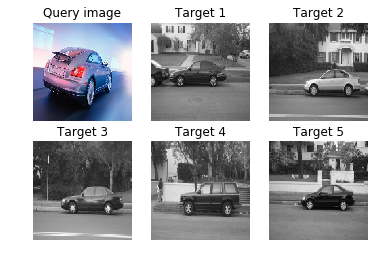

Image with non similar neighbors: 


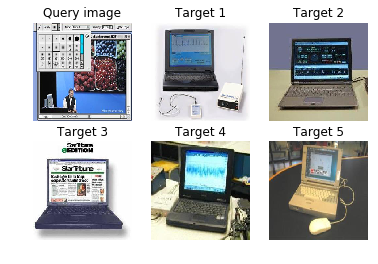

In [50]:
similar_query_index = 136
similar_query_path = bg_paths[similar_query_index]
similar_nn = nn_xfc.kneighbors(bg_fc2[similar_query_index].reshape(1, -1))
similar_images = similar_nn[1][0][:5]
print("Image with similar neighbors: ")
show_images(similar_query_path, similar_images, X_paths)

disimilar_query_index = 466
disimilar_query_path = bg_paths[disimilar_query_index]
disimilar_nn = nn_xfc.kneighbors(bg_fc2[disimilar_query_index].reshape(1, -1))
disimilar_images = disimilar_nn[1][0][:5]
print("Image with non similar neighbors: ")
show_images(disimilar_query_path, disimilar_images, X_paths)


The image contained in 'the background google dataset' with index 136 retrieves similar images. These similar images belong to the class 'car_side' in the caltech101 dataset.

Not all query images that retrieve all of its neighbors from the same class find relevant results. For example, image query 466 corresponds to a software presentation and the retrieved images are laptops. Also, query image with index 197 contains symbols from an alphabet but its neighbors are all images from the snoopy class.

***

**b)** Motivate your idea of "relevance": why do you consider the results for the first image relevant/similar, and those for the second image irrelevant/dissimilar?

**Answer:**

To find similar images for a query image, we used two main criteria:
* First, most retrieved images must belong to the same class, we consider these images as probably similar to the query image. If this doesn't happen then the retrieved images are considered disimilar because the query image will not be related to images from a single class.
* Second, the probably similar images must be related to query image. This is achieved through visual inspection of the relevant features of the query image and the retrieved images.

The process of finding similar images was partially automated. First, we ran queries to obtain probably similar images, and then we performed visual inspection. For dimisilar images we relied on the results obtained by our disimilar function.

***

**c)** Explain why you think this retrieval method (nearest neighbor for neural codes from VGG16) performs better on the first image than on the second.

**Answer:**

The first image can be easily associated to one of the existing categories. On the other hand, it is no clear to which class the second image belongs to. Because from visual inspection we have problems classifying the second image, it is understandable that the retrieval method performs poorly.

***

### Task 1.4: Dimensionality reduction

**a)** So far we've been using 4096-dimensional neural codes. This space is however still quite high-dimensional. Apply a dimensionality reduction method and evaluate the effect on the retrieval performance.

* Use PCA to obtain lower-dimensional representations of the Caltech101 data "fc2"-features (try the same compression rates as in Table 2 of the "Neural Codes for Image Retrieval" paper).
* Evaluate the same retrieval task as explained at the start of this question for each of the compression rates/dimensionalities. Report the retrieval scores.

*HINT: See http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on how to transform a dataset with PCA.*

In [24]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA

In [83]:
# load the data
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)
    
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

    ## compute score
def compressed_codes_score(indices, X_fc, y, dimension):
    total_score = 0
    
    # dimensionality reduction part
    pca = PCA(n_components=dimension)
    compressed_X = pca.fit_transform(X_fc)
    
    compressed_neigh = NearestNeighbors(n_neighbors=6, p=2)
    compressed_neigh.fit(compressed_X)
    X = compressed_X[indices]
    nn = compressed_neigh.kneighbors(X)
    nn_indices = nn[1]
    
    for neighbors in nn_indices:
        query = neighbors[0]
        query_class = y[query]
        closest_neighbors = neighbors[1:]
        neighbors_classes = y[closest_neighbors]
                
        for nclass in neighbors_classes:
            if query_class == nclass:
                total_score+=1
                
    score =(total_score*1.0)/n
    print("Average score for retrieval task using compressed images with {} dimensions is {:.2f}".format(dimension, score))

    
dimensions = [16, 32, 64, 128, 256, 512]
for dimension in dimensions:
    compressed_codes_score(indices, X_fc, y, dimension)

Average score for retrieval task using compressed images with 16 dimensions is 3.52
Average score for retrieval task using compressed images with 32 dimensions is 3.88
Average score for retrieval task using compressed images with 64 dimensions is 4.05
Average score for retrieval task using compressed images with 128 dimensions is 4.05
Average score for retrieval task using compressed images with 256 dimensions is 4.04
Average score for retrieval task using compressed images with 512 dimensions is 4.00


***

**b)** Discuss your results: how much can you further reduce the dimensionality of the data representations, without affecting the retrieval performance (much)? Compare these results to those from the paper, are your conclusions similar or not?

**Answer:**

Comparing the results obtained for the compressed codes with the precision obtained for the neural codes using "fc2"-features, we observe that it is possible to compress the neural codes up to 64 dimensions and still obtain good results for the retrieval task.

In the paper the authors explain that they are able to compress up to 128 dimensions without degrading the accuracy of the retrieval task. For our dataset we were able to compress up to 64 dimensions. This difference in dimensions could be associated to the smaller number of classes we are using on this assigment. Overall, we conclude that it is possible to use PCA to compress neural codes up to a certain threshold and still obtain good accuracy values in the retrieval task. This is a similar conclusion provided by the authors of the paper.

***

## Question 2: Fashion-MNIST (12.5pt)
For this question we will work with the "Fashion-MNIST" dataset. This dataset is modelled to have the same specifics as MNIST; it consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 greyscale image, associated with a label from one of 10 classes. The images represent various clothing items (as opposed to handwritten digits for MNIST), each class represents a different type of clothing item. The following classes exist:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In this question we will investigate various ways to model visual similarity for this dataset, in order to perform image retrieval. For more info about the dataset, see https://github.com/zalandoresearch/fashion-mnist.

The dataset can directly be obtained through Keras:

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


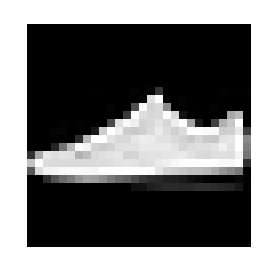

Class: Sneaker (7)


In [3]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# properties of the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# show an example
example_id = 340  # pick any integer from 0 to 59999 to visualize a training example
example = x_train[example_id].reshape(img_rows, img_cols)

label = y_train[example_id]
label_digit = y_train_digits[example_id]
label_class = classes[label_digit]
plt.matshow(example, cmap="gray")
plt.axis("off")
plt.show()
print("Class: {} ({})".format(label_class, label_digit))

#print(example.shape)
#example_mirrored = np.fliplr(x_train[example_id]).reshape(img_rows, img_cols)
#plt.matshow(example_mirrored, cmap="gray")
#plt.axis("off")
#plt.show()
#print("Class: {} ({})".format(label_class, label_digit))

Consider the following situation: We have a fully labelled dataset (the ***labelled set***) of the images from the first 5 classes (t-shirts/tops, trousers, pullovers, dresses, coats). We are then supplied with an unlabelled dataset (the ***retrieval set***) containing the remaining Fashion-MNIST images (sandals, shirts, sneakers, bags, ankle boots) on which we want to be able to perform image retrieval. So we cannot use labels from the retrieval set, since we do not know them (note that in our case we *do* have the labels, but we will only use them for evaluation).

The following code splits the dataset up into two sets representing 5 classes each. Observe that the labelled and the retrieval set have exactly the same size.

In [4]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 5).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 5).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 5).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 5).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :5]
y_train_r = y_train_r[:, 5:]
y_test_l = y_test_l[:, :5]
y_test_r = y_test_r[:, 5:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000, 5)
(30000, 5)
(30000,)
(30000,)
(5000, 28, 28, 1)
(5000, 28, 28, 1)
(5000, 5)
(5000, 5)
(5000,)
(5000,)


***

### Task 2.1: Fashion neural retrieval
**a)** Design an MLP (multilayer perceptron) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use `x_train_l` for training). You may include Dropout and BatchNormalization if needed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train it to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 90%) on the labelled test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [5]:
# import sequential model and layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

In [26]:
mlp = Sequential()

# === SOLUTION: ===
# Create a vector of the images in both the train and test data
dimData = np.prod(x_train_l.shape[1:])
x_train_l_vector = x_train_l.reshape(x_train_l.shape[0], dimData)
x_test_l_vector = x_test_l.reshape(x_test_l.shape[0], dimData)

mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(dimData,)))
mlp.add(Dropout(0.2))
mlp.add(Dense(128, activation='relu', name="neural_codes"))
mlp.add(Dropout(0.2))
mlp.add(Dense(5, activation='softmax'))

mlp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = mlp.fit(x_train_l_vector, y_train_l, batch_size=256, epochs=20, verbose=1, 
                   validation_data=(x_test_l_vector, y_test_l))

print(history)
[test_loss, test_acc] = mlp.evaluate(x_test_l_vector, y_test_l)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 2s 51us/step - loss: 0.5576 - acc: 0.7862 - val_loss: 0.4050 - val_acc: 0.8458
Epoch 2/20
30000/30000 [==============================] - 1s 26us/step - loss: 0.3808 - acc: 0.8583 - val_loss: 0.3710 - val_acc: 0.8622
Epoch 3/20
30000/30000 [==============================] - 1s 26us/step - loss: 0.3420 - acc: 0.8745 - val_loss: 0.3619 - val_acc: 0.8688
Epoch 4/20
30000/30000 [==============================] - 1s 26us/step - loss: 0.3190 - acc: 0.8818 - val_loss: 0.3231 - val_acc: 0.8756
Epoch 5/20
30000/30000 [==============================] - 1s 26us/step - loss: 0.2965 - acc: 0.8899 - val_loss: 0.4009 - val_acc: 0.8582
Epoch 6/20
30000/30000 [==============================] - 1s 26us/step - loss: 0.2876 - acc: 0.8950 - val_loss: 0.3195 - val_acc: 0.8856
Epoch 7/20
30000/30000 [==============================] - 1s 31us/step - loss: 0.2736 - acc: 0.9002 - val_loss: 0.2952 - val_acc:

In [27]:
# create directory if doesn't exist yet
try:
    os.mkdir("assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

In this question we chose for a model with three dense layer, from which the last layer only has 5 neurons, one for each of the possible classes. Both other dense layers have both 128 neurons. When running this model without the dropout layers that are implemented now the network was overfitting on the train data: accuracy there was more than 5 percent than on the test data. Adding the dropout layers reduced this to only 2 percent. For activation in the last layer both softmax and sigmoid are tried, softmax was performing slightly better, but not significant (<1%)

***

### Task 2.2: Fashion neural retrieval #2
**a)** Design a CNN (convolutional neural network) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use x_train_l for training), consisting of a number of Convolutions with Max-Pooling, followed by one or more Dense layers. You may use Dropout and BatchNormalization to improve generalization and training speed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train the CNN to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 94%) on the test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [11]:
# import additional layers
from keras.layers import Conv2D, MaxPooling2D

In [18]:

# === SOLUTION: ===
accuracy_threshold = 0.94

## data normalization
#X -= np.mean(X)

## I added the 500 dense layer after the network was having no performance better than 90%
## change from batches of size 1000 to batches of size 2000
## change from batch size of 2000 to 1500
## I am thinking about getting rid of the first maxpooling or the second maxpooling layer and running the model again
## I should normalize my inputs and/or generate data by mirroring the images


def train_cnn(no_filters_first_cnn_layer, no_filters_second_cnn_layer,  cnn_batch_size, epochs):
    cnn = create_first_model(no_filters_first_cnn_layer, no_filters_second_cnn_layer)
    #cnn = create_second_model(no_filters_first_cnn_layer, no_filters_second_cnn_layer)
    
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   
    cnn.fit(x_train_l, y_train_l, nb_epoch=epochs, batch_size=cnn_batch_size)
    return cnn
    
 
def select_cnn(no_filters_first_cnn_layer_list, no_filters_second_cnn_layer_list, cnn_batch_size, epochs):
    selected_cnn = None
    previous_acc = 0.0
    pairs_of_filters = [(x,y) for x in no_filters_first_cnn_layer_list for y in no_filters_second_cnn_layer_list]
    for no_filters in pairs_of_filters:
        cnn = train_cnn(no_filters[0], no_filters[1], cnn_batch_size, epochs)
        score = cnn.evaluate(x_test_l, y_test_l, batch_size=cnn_batch_size)
        acc = score[1]
        print("Cnn with {} filters in first cnn layer, {} filters in second cnn layer obtained {:.3f} test accuracy".format(no_filters[0],
                                                                                                                            no_filters[1],
                                                                                                                            acc))
        if selected_cnn == None:
            selected_cnn = cnn
            selected_cnn_acc = acc
        elif selected_cnn != None and acc > selected_cnn_acc:
            selected_cnn = cnn
            selected_cnn_acc = acc

    return selected_cnn
    


In [19]:
def create_first_model(no_filters_first_cnn_layer, no_filters_second_cnn_layer):
   
    cnn = Sequential()
    #filter_size = (5,5)

    # padding='same' is used to have outputs with the same dimension as the inputs
    cnn.add(Conv2D(filters=no_filters_first_cnn_layer, kernel_size=(3,3), input_shape=(28, 28, 1), 
       strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
    cnn.add(Conv2D(filters=no_filters_first_cnn_layer, kernel_size=(3,3), 
       strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
    # we want 14 x 14 x 6
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
  
    cnn.add(Conv2D(no_filters_second_cnn_layer, kernel_size=(3,3), 
       strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
    cnn.add(Dropout(0.20))
    cnn.add(Conv2D(no_filters_second_cnn_layer, kernel_size=(3,3), 
       strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
    #cnn.add(Dropout(0.20))
    # we want 7 x 7 x 60
    #cnn.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
    # we obtain a vector with about 3000 dimensions
    cnn.add(Flatten())
    # we want to have 1/6 of the previous vector size
    cnn.add(Dense(384, activation="relu"))
    cnn.add(Dense(128, activation="relu", name="neural_codes"))
    # softmax classifier
    cnn.add(Dense(5, activation="softmax"))
        
    return cnn

def create_second_model(no_filters_first_cnn_layer, no_filters_second_cnn_layer):
    cnn = Sequential()
    #filter_size = (5,5)
    # padding='same' is used to have outputs with the same dimension as the inputs
    cnn.add(Conv2D(filters=no_filters_first_cnn_layer, kernel_size=(3,3), input_shape=(28, 28, 1), 
       strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
    # we want 14 x 14 x 6
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
  
    cnn.add(Conv2D(no_filters_second_cnn_layer, kernel_size=(3,3), 
       strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
    cnn.add(Dropout(0.20))

    #cnn.add(Dropout(0.20))
    # we want 7 x 7 x 60
    #cnn.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
    # we obtain a vector with about 3000 dimensions
    cnn.add(Flatten())
    # we want to have 1/6 of the previous vector size
    cnn.add(Dense(384, activation="relu"))
    cnn.add(Dense(128, activation="relu", name="neural_codes"))
    # softmax classifier
    cnn.add(Dense(5, activation="softmax"))
        
    return cnn
    
    

In [20]:
### select the best cnn model using only train and test sets
no_filters_first_cnn_layer_list = [6, 8, 10]
no_filters_second_cnn_layer_list = [14, 16, 18]
#no_filters_third_cnn_layer_list = [6, 8, 10, 12]
batch_size = 1500
epochs = 20
cnn_model = select_cnn(no_filters_first_cnn_layer_list, 
                      no_filters_second_cnn_layer_list,
                      batch_size, epochs)


/home/jorge/.local/share/virtualenvs/RecommenderSystems-c5N1t04d/lib/python3.5/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
30000/30000 [==============================] - 28s 946us/step - loss: 0.8404 - acc: 0.7380
Epoch 2/20
30000/30000 [==============================] - 28s 942us/step - loss: 0.4114 - acc: 0.8480
Epoch 3/20
30000/30000 [==============================] - 28s 942us/step - loss: 0.3468 - acc: 0.8753
Epoch 4/20
30000/30000 [==============================] - 28s 933us/step - loss: 0.3146 - acc: 0.8862
Epoch 5/20
30000/30000 [==============================] - 30s 990us/step - loss: 0.2959 - acc: 0.8932
Epoch 6/20
30000/30000 [==============================] - 29s 952us/step - loss: 0.2804 - acc: 0.8974
Epoch 7/20
30000/30000 [==============================] - 29s 951us/step - loss: 0.2567 - acc: 0.9095
Epoch 8/20
30000/30000 [==============================] - 28s 933us/step - loss: 0.2399 - acc: 0.9137
Epoch 9/20
30000/30000 [==============================] - 29s 975us/step - loss: 0.2225 - acc: 0.9209
Epoch 10/20
30000/30000 [==============================] - 28s 938us/step - loss: 

30000/30000 [==============================] - 38s 1ms/step - loss: 0.2356 - acc: 0.9141
Epoch 11/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.2232 - acc: 0.9193
Epoch 12/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.2153 - acc: 0.9226
Epoch 13/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.2056 - acc: 0.9240
Epoch 14/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.2013 - acc: 0.9273
Epoch 15/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.1896 - acc: 0.9322
Epoch 16/20
30000/30000 [==============================] - 37s 1ms/step - loss: 0.1857 - acc: 0.9321
Epoch 17/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.1882 - acc: 0.9318
Epoch 18/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.1781 - acc: 0.9346
Epoch 19/20
30000/30000 [==============================] - 38s 1ms/step - loss: 0.1700 - acc: 0.9393
Ep

In [21]:
#y_train_l
#y_train_r
#y_test_l 
#y_test_r 

## how to select the right batch size
## for now lets use a batch size of 1000
final_score = cnn_model.evaluate(x_test_l, y_test_l, batch_size=batch_size)
print("Accuracy for final model {:.3f}".format(final_score[1]))


5000/5000 [==============================] - 2s 458us/step
Accuracy for final model 0.938


In [22]:
# save the model
cnn_model.save(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

For this exercise we started working with a similar architecture to Lenet5. After several failed attempts to reach the 94% accuracy value on the test set, we decided to generate two simple architectures that were trained with different number of convolutional filters. The size of the filters was set 3x3 because that is the size that appears most frequently in the computer vision literature. 

The first architecture consists of two convolutional layers followed by a max pool of size 2x2 with a stride of 2. We expect that the first two filters find relevant information about the elemental features in the images. For example, corners, curves, width, height, and colored regions. The max pool layer is used to reduce the number of parameters needed for the rest of the network. After the max pool layer, there is a convolutional layer followed by a dropout layer followed by another convolutional layer. Here we want to obtain complicated features like: pockets, waistbands, bottoms, legs, etc. The dropout layer is used to reduce the complexity of the network without discarding as much information as with a max pool layer. Finally, we use three fully connected layers. The first fully connected layer exists to allow the second one to compute more complex representations of the features obtained by the last convolutional layer. The third fully connected layer is the one we use for the classification task. That's why it contains a softmax activation function. ReLu activations functions are used in almost every layer, and padding was added to avoid shrinking the dimensions of the output of each convolutional layer.

The second architecture is very similar to the first one. With the only difference that here we only used two convolutional layers to detect features. The first one is followed by a max pool layer, and the second one is followed by a dropout layer. The number of fully connected layers and their dimensions are the same as for the first network.

None of both architectures reached the 94% test accuracy goal, but the first one obtained 93.8%. We considered this value close enough to 94% to select the corresponding model. After applying data transformation techniques, we were able to obtain a little bit more than 94% of accuracy with the same architectures. At the end, we decided to train the data in the original data to have a simpler comparison between different models.

***

### Task 2.3: Fashion neural retrieval #3
**a)** Design a (convolutional) Denoising Autoencoder (DAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the DAE to reconstruct noisy images to the original input images. Make sure that it achieves a binary cross-entropy loss of at most 0.29 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [9]:
# import additional layer
from keras.layers import UpSampling2D, Reshape

In [12]:
# obtain noisy version of data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# define autoencoder
dae = Sequential()

# === SOLUTION: ===
filter_amount = 8

# encoding part
dae.add(Conv2D(input_shape=(28, 28, 1), filters=filter_amount, kernel_size=(3,3), 
               strides=(1, 1), padding='same', activation="relu", kernel_initializer='glorot_uniform'))
dae.add(MaxPooling2D((2, 2), border_mode='same'))
dae.add(Flatten())
# add activity regularizer for this node
dae.add(Dense(128, activation="relu", name="neural_codes"))

# decoding part
dae.add(Dense(1568, activation="relu"))
dae.add(Reshape((14, 14, 8)))
dae.add(Conv2D(filters=filter_amount, kernel_size=(3,3), strides=(1, 1), padding='same', 
               activation="relu", kernel_initializer='glorot_uniform'))
dae.add(UpSampling2D(size=(2, 2)))
dae.add(Conv2D(filters=1, kernel_size=(1,1), strides=(1, 1), padding='same', 
               activation="sigmoid", kernel_initializer='glorot_uniform'))
dae.compile(optimizer='rmsprop', loss='mean_squared_error')

dae.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                verbose=1,
                validation_data=(x_test_noisy, x_test))
test_loss = dae.evaluate(x_test_noisy, x_test)
print("Evaluation result on Test Data : Loss = {}".format(test_loss))

/home/mathyn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 20s 333us/step - loss: 0.0568 - val_loss: 0.0371
Epoch 2/20
60000/60000 [==============================] - 19s 315us/step - loss: 0.0340 - val_loss: 0.0320
Epoch 3/20
60000/60000 [==============================] - 20s 327us/step - loss: 0.0302 - val_loss: 0.0307
Epoch 4/20
60000/60000 [==============================] - 21s 343us/step - loss: 0.0284 - val_loss: 0.0278
Epoch 5/20
60000/60000 [==============================] - 22s 368us/step - loss: 0.0272 - val_loss: 0.0274
Epoch 6/20
60000/60000 [==============================] - 19s 311us/step - loss: 0.0264 - val_loss: 0.0259
Epoch 7/20
60000/60000 [==============================] - 20s 332us/step - loss: 0.0258 - val_loss: 0.0257
Epoch 8/20
60000/60000 [==============================] - 21s 349us/step - loss: 0.0253 - val_loss: 0.0260
Epoch 9/20
60000/60000 [==============================] - 18s 307us/step - loss: 0.0250 - val_

In [13]:
# save the model
dae.save(os.path.join("assignment2_models", "dae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

For the encoder we used an convolutional layer and a maxpool layer wich reduced the 28x28x1 image into 14x14x8. Because of this dimension the decoder stars with a dense layer of 1568 neurons, followed by a convolutional and an upscaling layer. Finished by a last convolutional layer to reduce the dimensions from 8 to 1. For loss function we both tried cross-entropy and mean squared error, where MSE outperformed cross entropy significantly.

***

Visualise a few test examples, their noisy versions, and their reconstructions.

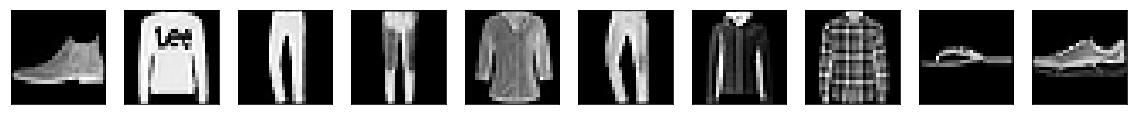

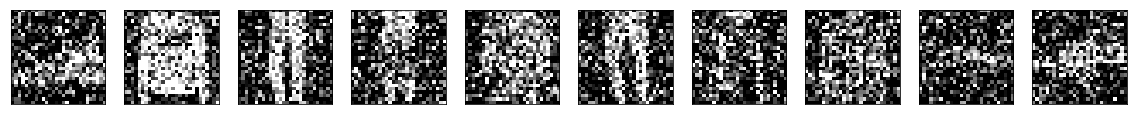

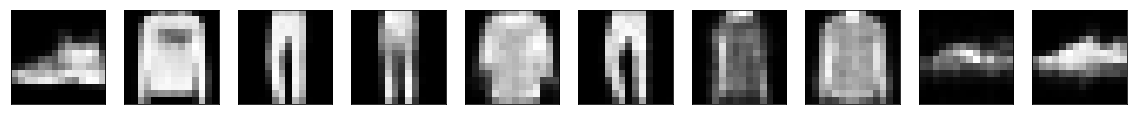

In [15]:
# NOTE: you don't need to change this code, just run it after having trained the DAE
batch_size=256
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = dae.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

**c)** Do you consider the results acceptable? Do you think they can be useful for image retrieval? Explain why in one or two sentences.

**Answer:**

The results are acceptable in a way that the noise is removed and the shape of the objects is better visible, however details like the text on the shirt could not be reconstructed using this auto-encoder.

***

**d)** Why can we train on the full dataset `x_train` here, whereas in Tasks 2.1 and 2.2 we had to use `x_train_l` (the first 5 classes only) for training?

**Answer:**

Because in 2.1 and 2.2 the goal was classification and images of sandal and sneakers in this dataset with this resolution are so similar that it is hard to classify them correctly without overfitting. While in 2.3 the assignment is to remove noise of the images, the classes are not relevant, making the full dataset usefull to remove noise.

***

### Task 2.4: Fashion neural retrieval #4
Autoencoders come in different shapes and sizes. One key defining property of autoencoders is the means the model uses to prevent the learning of the identity function. Typically, this is done with different regularization methods. In the previous task you used a model that uses noise as a regularizer. In this task you will develop a Sparse Autoencoder (SAE). A sparse autoencoder uses a sparsity regularization to obtain sparse representations of the input data. Sparsity can be achieved by using L1-regularization on the activations of the hidden "code" layer.

**a)** Design a (convolutional) Sparse Autoencoder (SAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). Add an activity regularizer to this layer, using `regularizers.l1(10e-5)` from Keras.
For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the SAE to reconstruct input images. Make sure that it achieves a loss value of at most 0.31 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [51]:
# import regularizers for sparse autoencoder
from keras import regularizers


In [85]:
# define autoencoder
sae = Sequential()

# === SOLUTION: ===
# insert code here
no_filters = 32

# encoding part: 
#input = 28 x 28 x 1, output = 28 x 28 x 32
sae.add(Conv2D(filters=no_filters, kernel_size=(3,3), input_shape=(28, 28, 1), padding='same', activation="relu"))
# input = 28 x 28 x 32, output = 14 x 14 x 32
sae.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
sae.add(BatchNormalization())
# input = 14 x 14 x 32, output = 14 x 14 x 32
sae.add(Conv2D(no_filters, kernel_size=(3,3), padding='same', activation="relu"))
# input = 14 x 14 x 32, output = 7 x 7 x 32
sae.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
sae.add(BatchNormalization())
# input = 7 x 7 x 32, output = 1568 x 1
sae.add(Flatten())
# input = 1568 x 1, output = 128 x 1
sae.add(Dense(128, activation="relu", activity_regularizer=regularizers.l1(10e-5), name="neural_codes"))

# decoding part:
# input = 128 x 1, output = 1568 x 1
sae.add(Dense(7*7*no_filters, activation="relu"))
# input = 1568 x 1, output = 7 x 7 x 32
sae.add(Reshape((7, 7, no_filters)))
# input = 7 x 7 x 32, output = 7 x 7 x 32
sae.add(Conv2D(no_filters, kernel_size=(3,3), padding='same', activation="relu"))
# input = 7 x 7 x 32, output = 14 x 14 x 32
sae.add(UpSampling2D(size=(2, 2)))
sae.add(BatchNormalization())
# input = 14 x 14 x 32, output = 14 x 14 x 32
sae.add(Conv2D(no_filters, kernel_size=(3,3), padding='same', activation="relu"))
# input = 14 x 14 x 32, output = 28 x 28 x 32
sae.add(UpSampling2D(size=(2, 2)))
sae.add(BatchNormalization())

# input = 28 x 28 x 32, output = 28 x 28 x 1
sae.add(Conv2D(1, kernel_size=(3,3), padding='same', activation="sigmoid"))

sae.compile(optimizer='adam', loss='binary_crossentropy')


In [86]:
sae_batch_size = 100
epochs = 10
#sae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
sae.fit(x_train, x_train, nb_epoch=epochs, batch_size=sae_batch_size, validation_split=1/12)


/home/jorge/.local/share/virtualenvs/RecommenderSystems-c5N1t04d/lib/python3.5/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 245s 4ms/step - loss: 0.3773 - val_loss: 0.3487
Epoch 2/10
55000/55000 [==============================] - 239s 4ms/step - loss: 0.3368 - val_loss: 0.3371
Epoch 3/10
55000/55000 [==============================] - 239s 4ms/step - loss: 0.3305 - val_loss: 0.3367
Epoch 4/10
55000/55000 [==============================] - 239s 4ms/step - loss: 0.3261 - val_loss: 0.3256
Epoch 5/10
55000/55000 [==============================] - 240s 4ms/step - loss: 0.3215 - val_loss: 0.3222
Epoch 6/10
55000/55000 [==============================] - 240s 4ms/step - loss: 0.3179 - val_loss: 0.3168
Epoch 7/10
55000/55000 [==============================] - 239s 4ms/step - loss: 0.3135 - val_loss: 0.3233
Epoch 8/10
55000/55000 [==============================] - 240s 4ms/step - loss: 0.3089 - val_loss: 0.3072
Epoch 9/10
55000/55000 [==============================] - 239s 4ms/step - loss: 0.3042 - val_loss: 0.30

In [87]:
final_score = sae.evaluate(x_test, x_test, batch_size=sae_batch_size)
#print(final_score)
print("Loss in the test set {:.3f}".format(final_score))


10000/10000 [==============================] - 14s 1ms/step
Loss in the test set 0.303


In [88]:
# save the model
sae.save(os.path.join("assignment2_models", "sae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

Our autoencoder uses a simple architecture for the encoder and the decoder.

The encoder is constructed using the following layers:
* Convolutional layer (32 filters)
* Max pooling layer (2x2)
* Batch normalization layer 
* Convolutional layer (32 filters)
* Max pooling layer (2x2)
* Batch normalization layer
* Flatten layer
* Dense layer with 128 units

The first convolutional filter is used to capture simple features in the images, and the second convolutional filter is used to capture complex features in the images. Max pooling layers are used after convolutional layers to reduce the number of parameters that next layers have to work with. To improve the training procedure we use batch normalization layers because the number of parameters used in our network is large. The final layer of the encoder ("code layer") is the dense layer with 128 units. This layer is used to represent the encoded images as vectors of features.


The decoder is constructed using the following layers:
* Dense layer with 1568 units
* Reshape layer
* Convolutional layer (32 filters)
* Up sampling layer (2x2)
* Batch normalization layer
* Convolutional layer (32 filters)
* Up sampling layer (2x2)
* Batch normalization layer
* Convolutional layer with only one filter

The first dense layer with 1568 units is used to scale our code layer. After scaling our code layer, we reshape the dense layer with 1568 units into a layer with 7 x 7 x 32 units. Then, two grups formed by a convolutional layer, an up sampling layer, and a batch normalization layers are applied. The last convolutional layer is used to obtain a figure of size 28 x 28 x 1 to be able to train our autoencoder using images of size 28 x 28 x 1. The first convolutional layer is used to reconstruct complex features from the images, and the second convolutional layer is used to reconstruct simple features from the images. Using the features of the second convolutional layer, the third convolutional layer should be able to reconstruct the input images. 

This architecture was created after several failed attemps. The first versions of this autoencoder only have 8 filters per convolutional layer and didn't have batch normalization layers. Because the results were not satisfactory, we increased the number of filters to 24. Using 24 filters we obtained better results but didn't achieve the required loss value. We increased the number of filters by two units until we reached 32. It was here that we added batch normalization because the network became very slow to train. We stop modifiyng our autoencoder after we obtained a good loss value using 32 filters in each convolutional layer. 

***

Visualise a few test examples and their reconstructions.

In [ ]:
# NOTE: you don't need to change this code, just run it after having trained the SAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr = sae.predict(x_test, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_reconstr)

**c)** Compare the visual results to those of the DAE in Task 2.3. Also compare the loss values of the test set for the DAE and SAE. How can you explain the difference?

**Answer:**

*=== write your answer here ===*

***

### Task 2.5: Comparison
Obtain 128-dimensional neural code representations of the last five classes of the Fashion-MNIST dataset (the *retrieval set*: `x_train_r`) from the following models/layers:
1. The last dense hidden layer (before the output layer) of the MLP you trained in Task 2.1
2. The last dense hidden layer (before the output layer) of the CNN you trained in Task 2.2
3. The center layer/code of the DAE you trained in Task 2.3
4. The center layer/code of the SAE you trained in Task 2.4
5. A PCA-transformation

In [16]:
# additional imports
from keras.models import load_model
from keras.models import Model

In [ ]:
dimData = np.prod(x_train_r.shape[1:])

# load the previously trained and saved models
mlp = load_model(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))
cnn = load_model(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))
dae = load_model(os.path.join("assignment2_models", "dae_fashionmnist.h5"))
sae = load_model(os.path.join("assignment2_models", "sae_fashionmnist.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
mlp_nc = Model(inputs=mlp.input, outputs=mlp.get_layer("neural_codes").output)
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes").output)
dae_nc = Model(inputs=dae.input, outputs=dae.get_layer("neural_codes").output)
sae_nc = Model(inputs=sae.input, outputs=sae.get_layer("neural_codes").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# Convert images to vectors
x_train_r_vector = x_train_r.reshape(x_train_r.shape[0], dimData)
x_test_r_vector = x_test_r.reshape(x_test_r.shape[0], dimData)

# train PCA on the retrieval set
pca = PCA(n_components=128)
pca.fit(x_train_r_flat)

# obtain 128-dimensional representations
nc_mlp_train = mlp_nc.predict(x_train_r_vector)
nc_mlp_test = mlp_nc.predict(x_test_r_vector)
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)
nc_dae_train = dae_nc.predict(x_train_r)
nc_dae_test = dae_nc.predict(x_test_r)
nc_sae_train = sae_nc.predict(x_train_r)
nc_sae_test = sae_nc.predict(x_test_r)
nc_pca_train = pca.transform(x_train_r_flat)
nc_pca_test = pca.transform(x_test_r_flat)

# print the shapes to confirm all features are 128-dimensional
print(nc_mlp_train.shape)
print(nc_mlp_test.shape)
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)
print(nc_dae_train.shape)
print(nc_dae_test.shape)
print(nc_sae_train.shape)
print(nc_sae_test.shape)
print(nc_pca_train.shape)
print(nc_pca_test.shape)

***

**a)** Evaluate the retrieval task as described in Question 1 on the last 5 classes (the retrieval set) of the Fashion-MNIST dataset, for the five data representations given above. Use query images from the test set and retrieve images from the training set only. Print the five resulting retrieval scores (between 0 and 5).

*HINT: you can use* `y_train_digits_r` *and* `y_test_digits_r` *to obtain digit encodings (as opposed to one-hot encodings) of the data labels.*

In [ ]:
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 5000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

representations = [
    (nc_mlp_train, nc_mlp_test),
    (nc_cnn_train, nc_cnn_test),
    (nc_dae_train, nc_dae_test),
    (nc_sae_train, nc_sae_test),
    (nc_pca_train, nc_pca_test),
]
for (nc_train, nc_test) in representations:
    # === SOLUTION: ===
    # insert code here

***

**b)** Compare the "baseline" PCA-transformed data with the other methods. Is PCA a suitable method to obtain representations for image retrieval in this situation? Why do you think so? Would you expect a similar conclusion for the Caltech101 dataset from Question 1?

**Answer:**

*=== write your answer here ===*

***

Observe the difference between encodings from the DAE and SAE.

In [ ]:
print("Mean activation for DAE encodings:", np.mean(nc_dae_train))
print("Mean activation for SAE encodings:", np.mean(nc_sae_train))

index = 1  # try a few indices here
print("DAE encoding example:")
print(nc_dae_train[index])
print("SAE encoding example:")
print(nc_sae_train[index])

**c)** Discuss the difference in encodings between the two autoencoders (denoising and sparse). Also discuss the difference in retrieval performance for these encodings. How would you explain this difference?

**Answer:**

*=== write your answer here ===*

***

**d)** What is the best performing method you found in part a)? Describe what advantage you believe this method has over the others.

**Answer:**

*=== write your answer here ===*